# Introducción
## Descripción
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.
## Objetivo
Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.
## Tabla de contenido
- Introducción
- Preprocesamiento de la información
- Modelo de clasificación: Sección donde se trabaja de manera detallada tanto clases desbalanceadas como balanceadas, evaluación de calidad del modelo.
- Evaluación del modelo bajo el enfoque de "Ajuste de peso de clases": Creación y ajuste del modelo haciendo uso del enfoque con mejor desempeño según la evaluación de calidad.
- Conclusiones

# Preprocesamiento de los datos
Comenzaremos con la importanción y estudio de los datos proporcionados en el archivo `Churn.csv` con la intención de preparar los datos para posteriormente hacer uso de los mismos.

In [1]:
# Importando librerias
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.utils import shuffle

In [2]:
# Importando y validando la información de "Churn.csv"
data = pd.read_csv('datasets/Churn.csv')
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
# Verificando información contenida en "data"
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


De acuerdo con lo obtenido de información podemos destacar algunas cuestiones que hay que corregir antes de poder utilizar `data` y son las siguientes:
- Las columnas están tituladas con letra capital, por buenas prácticas, estas deben estar en minusculas.
- Nos encontramos con valores nulos en la columna `Tenure`, en total `909` registros.
- En la columna `Surname` podemos observar que dentro de los primeros 10 registros, aparece uno con caracteres especiales (`?`) por lo que es importante verificar esta posibilidad en todos los registros.
- Dejaremos abierta la posibilidad de hacer cambio de tipo de datos para alguna de las columnas.
- Hay columnas que no nos aportan información que se notan a simple vista, tal es el caso de `RowNumber`, `CustomerId` (y posiblemente `Surname`).

Comenzaremos por el renombramiento de las columnas para que este homologadas y eliminación de la columna que no nos aporta información.

In [4]:
# Ajuste de nombre de columnas
data.drop(['RowNumber','CustomerId'],axis=1,inplace=True)
data.rename(columns={'Surname':'surname',
                    'CreditScore':'creditScore',
                    'Geography':'geography',
                    'Gender':'gender',
                    'Age':'age',
                    'Tenure':'tenure',
                    'Balance':'balance',
                    'NumOfProducts':'numOfProducts',
                    'HasCrCard':'hasCrCard',
                    'IsActiveMember':'isActiveMember',
                    'EstimatedSalary':'estimatedSalary',
                    'Exited':'exited'},inplace=True)
data.head()

,surname,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Con la intención de no trabajar con registros duplicados, procederemos con esta validación evitando procesamiento inecesario.

In [5]:
# Encontrando registros duplicados
data.duplicated().sum()

0

De acuerdo con el resultado, no contamos con registros duplicados. Por tal motivo, podemos continuar con el preprocesamiento de la inforamción por lo que comenzaremos a trabajar con la columna `surname` y aquellos registros que cuentan con algún caracter especial que no sea congruente con la información proporcionada. Comenzaremos con la exploración de estos registros antes de hacer modificaciones pues de forma intuitiva, podemos mencionar que el `surname` no es un dato influyente en la permanencia o abandono del banco.

In [6]:
# Encontrando la cantidad de registros únicos en la columna "surname"
len(data['surname'].unique())

2932

In [7]:
# Trabajando con la columna "surname" y los registros con caracteres especiales
surname = []
for s in data['surname']:
    if len(re.findall('([^a-zA-Z ]+)',s)) != 0:
        surname.append(s)
print(surname)
print(len(surname))

['H?', "O'Brien", "T'ien", "T'ang", "T'ang", "T'ao", "Ch'ien", "O'Sullivan", "Ch'iu", "K'ung", "Ch'ien", "O'Donnell", "Ts'ai", 'L?', "K'ung", "T'ang", 'Hs?', "Ch'en", 'Wentworth-Shields', "Ts'ao", "Ch'ang", "Ch'iu", "Ts'ai", "K'ung", "P'an", "Ts'ai", "Ts'ui", "P'eng", "Ch'eng", "Ch'eng", "O'Loghlen", "T'ien", "Ch'en", "Ts'ai", 'Y?an', "Ch'en", "Ch'in", "Ts'ui", "Ch'iu", 'L?', 'Y?an', "Ch'iu", "Ts'ui", 'Winter-Irving', 'L?', "O'Neill", 'Drake-Brockman', 'H?', "Ch'iu", "T'an", "T'ao", "T'ang", "P'eng", "K'ung", 'K?', "O'Brien", "Ts'ai", "D'Albertis", 'L?', "P'an", "Ch'ien", 'Hs?', "T'ang", 'H?', "P'eng", 'Y?', "P'eng", "Ts'ao", "T'an", "O'Meara", "T'ien", "K'ung", "T'ao", 'Y?', "Ch'eng", "O'Toole", 'L?', "Ch'iu", 'H?', "P'an", "Ts'ai", "K'ung", "Ts'ui", "P'eng", "Ch'eng", "Ts'ui", 'Y?an', 'H?', "P'eng", 'Y?', 'Hs?', 'Y?', "Ts'ai", "Ch'ang", "Ts'ui", 'L?', 'Hs?', "P'eng", "T'ien", "O'Connor", "K'ung", 'K?', 'Warlow-Davies', "Ts'ai", 'Y?', "O'Sullivan", 'Hs?eh', "Ts'ai", "Ch'ien", "Ts'ai",

Como podemos observar, hay una cantidad considerable de `surname` que tiene caracteres especiales que afectan el dato como tal, como por ejemplo `'`, `-` o `?`. Esto, como anteriormente se menciona, de manera intuitiva no presentaría alguna relación sobre el abandono o permanencia dentro del banco.

De acuerdo con lo anterior, contamos con `2932` registros únicos refiriendonos a la columna `surname` de los cuales `348` son aquellos registros que cuentan con caracteres especiales. El `apellido` de un cliente no es un registro representativo para la decisión de abandono o no de cualquier de los servicios que proporionan los bancos, por tal motivo, procederemos con la eliminación de la columna con la intención de evitar procesamiento inecesario.

In [8]:
# Eliminando la columna "surname"
data.drop(['surname'],axis=1,inplace=True)
data

,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Continuaremos con los valores nulos presentes en la columna `tenure`. Procederemos con la visualización de la distribución de los valores.

<AxesSubplot:title={'center':'Distribución de la columna "tenure".'}, xlabel='Años', ylabel='Cantidad'>

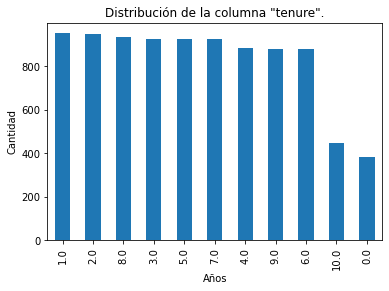

In [9]:
# Visualización de la distribución de la columna "tenure"
tenure_dist = data['tenure'].value_counts().sort_values(ascending=False)
tenure_dist.plot(kind='bar',title='Distribución de la columna "tenure".',xlabel='Años',ylabel='Cantidad')

De acuerdo con la gráfica podemos observar que en su mayoría, los valores de la columna `tenure` que están entre `1` y `9` tienen aproximadamente la misma cantidad de registros, exceptuando los valores de `10` y `0`. A continuación presentaremos la correlación de la información contenida.

In [10]:
# Tabla de correlación del dataframe "data"
data.corr()

,creditScore,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
creditScore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
numOfProducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
hasCrCard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
isActiveMember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimatedSalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


De acuerdo con la tabla de correlación, podemos observar que la columna `tenure` no tiene una correlación considerable con alguna otra de las columnas presentes en `data`. Por tal motivo, desde este punto, trabajaremos con las columnas que tiene información categórica con la intención de identificar una posible correlación que permita encontrar los posibles valores para `tenure`.

In [11]:
# Trabajando con las columnas "geography" y "gender"
le = LabelEncoder()
new_data = data.copy()
new_data['geography'] = le.fit_transform(data['geography'])
new_data['gender'] = le.fit_transform(data['gender'])
new_data

,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
0,619,0,0,42,2.0,0.00,1,1,1,101348.88,1
1,608,2,0,41,1.0,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8.0,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1.0,0.00,2,0,0,93826.63,0
4,850,2,0,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5.0,0.00,2,1,0,96270.64,0
9996,516,0,1,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,0,0,36,7.0,0.00,1,0,1,42085.58,1
9998,772,1,1,42,3.0,75075.31,2,1,0,92888.52,1


In [12]:
# Encontrando correlación en "new_data"
new_data[['geography','gender','tenure']].corr()

,geography,gender,tenure
geography,1.000000,0.004719,-0.000888
gender,0.004719,1.000000,0.012634
tenure,-0.000888,0.012634,1.000000


Como podemos obsevar en la tabla contemplando el resto de columnas (`geography` y `gender`) para lo cual no encontramos una correlación significativa que nos pueda brindar algún patrón de relación con la columna `tenure`. Por tal razón procederemos sin tomar en cuenta estos registros pero antes, evaluaremos cuál es la cantidad de registros eliminada de aquellos con valores nulos en la columna `tenure`.

In [13]:
# Conteo del total de registros en la columna "exited"
data['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [14]:
# Conteo del total de registros nulos en "tenure" para la columna "exited"
data[data['tenure'].isna()]['exited'].value_counts()

0    726
1    183
Name: exited, dtype: int64

De acuerdo con el resultado, si hacemos la eliminación de los registros nulos en la columna `tenure`, obtendremos un total de `706` clientes que no se han ido contral `183` que si se han ido de un total de `7963` y `2037` respectivamente, es decir, un total del `9%` aproximadamente de los registros para ambas clases será eliminado. Este cálculo se realizo con la intención de asegurarnos de no eliminar una gran cantidad de registros de la clase minorista.

In [15]:
# Omitiendo registros nulos en la columna "tenure"
data = data[data['tenure'].isna() != True]
data.reset_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            9091 non-null   int64  
 1   creditScore      9091 non-null   int64  
 2   geography        9091 non-null   object 
 3   gender           9091 non-null   object 
 4   age              9091 non-null   int64  
 5   tenure           9091 non-null   float64
 6   balance          9091 non-null   float64
 7   numOfProducts    9091 non-null   int64  
 8   hasCrCard        9091 non-null   int64  
 9   isActiveMember   9091 non-null   int64  
 10  estimatedSalary  9091 non-null   float64
 11  exited           9091 non-null   int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 852.4+ KB


Con lo anterior a partir de este punto trabajaremos con un total de `9091` registros.

Procederemos por el cambio de tipo de dato pues no es necesario que sean del tipo `float64`, por tal razón, las convertiremos al tipo `int64`.

In [16]:
# Cambiando el tipo de dato de la columna "tenure"
data['tenure'] = data['tenure'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            9091 non-null   int64  
 1   creditScore      9091 non-null   int64  
 2   geography        9091 non-null   object 
 3   gender           9091 non-null   object 
 4   age              9091 non-null   int64  
 5   tenure           9091 non-null   int64  
 6   balance          9091 non-null   float64
 7   numOfProducts    9091 non-null   int64  
 8   hasCrCard        9091 non-null   int64  
 9   isActiveMember   9091 non-null   int64  
 10  estimatedSalary  9091 non-null   float64
 11  exited           9091 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 852.4+ KB


/var/folders/g2/6f4slx3d02g5s4th9bbb102m0000gn/T/ipykernel_20236/1520822645.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tenure'] = data['tenure'].astype('int64')


Una vez que se verifica que los datos ya se encuentran listos para ser procesados, debemos identificar que tipo de modelo será el más adecuado dependiendo del problema presente en nuestros datos. Para esto, es claro que la columna objetivo se llama `exited` la cuál nos indica que si cliente se ha ido (`1`) o no (`0`); también es claro que nos enfrentamos a un problema de clasificación binario, esto es porque solo podremos tener dos valores posibles de salida.

Con la intención de asegurarnos al 100% de que estas son las únicas dos clases con las que cuenta la columna, examinaremos su contenido.

In [17]:
# Examinando la columna "exited"
data['exited'].value_counts()

0    7237
1    1854
Name: exited, dtype: int64

Como podemos obsevar nos encontramos con un desbalance de clases en nuestra columna objetivo, es decir, contamos con una cantidad resultados considerablemente mayor para la clase `0` (se quedan los clientes) que para la clase `1` (los clientes que se van). Por el momento definiremos cuál de los modelos de `Machine Learning` de clasificación es el más adecuado para los datos.

# Modelo de clasificación

A continuación se presentará brevemente el uso de los algoritmos a considerar para el modelo de predicción.

- **Árboles de decisión**: Dado un conjunto de datos se fabrican diagramas de construcción lógicas, que sirven para representar y categorizar una serie de condiciones que ocurren de forma sucesiva.
- **Regresión logística**: Es el análisis de regresión apropiado para realizar cuando la variable dependiente es binaria. Como todos los análisis de regresión, la regresión logística es un análisis predictivo.
- **Bosques aleatorios**: Los Bosques Aleatorios tienen una variedad de aplicaciones, tales como motores de recomendación, clasificación de imágenes y selección de características.

De acuerdo con los usos de los diferentes modelos, podemos identificar que todos pueden ser utilizados para la resolución de la problematica en estos datos, por tal motivo, entrenaremos los distintos modelos variando sus híper parámetros para identificar aquellos que tienen un mejor desempeño. Todo esto será aplicado sin tener en cuenta el desequilibrio de clases.

## Entrenamiento y evaluación de modelos (con desequilibrio de clases)

### Preprocesamiento de entrenamiento

Comenzaremos nuevamente analizando la información que nos proporciona `data` para ajustar los datos a lo requerido por los modelos de clasificación de la librería `scikitlearn`.

In [18]:
# Visualizando información de "data"
data.head()

,index,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
0,0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Como podemos observar, contamos con 2 columnas con registros categóricos, es decir, la información contenida dentro de las columnas `geography` y `gender`, ademas de `tenure` que ya fue trabajada, son un set definido de parámetros.

Exploraremos que parámetros contiene cada columna para verificar como van a ser trabajadas posteriormente.

In [19]:
# Examinando la columna "geography"
data['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

Para la columna `geography` podemos observar que tenemos 3 categorias:
- France
- Germany
- Spain

Continuaremos examinando la columna `gender` que es de esperar que sean unicamente dos categorías pero hay que asegurarnos de ello.

In [20]:
# Examinando la columna "gender"
data['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

Como era de esperarse, la columna `gender` tiene unicamente 2 categorías. Una vez conociendo estos datos y algo a destacar es que los modelos de `Machine Learning` procesan unicamente datos numéricos, por tal motivo es necesario cambiar estos datos categóricos a datos numéricos y hay dos procesos para hacerlo y son:

- `One Hot Encoder`: Es un proceso que se aplica para los modelos de regresión puesto que estos modelos tienen acceso a todo el espectro de variables al mismo tiempo.
- `Label Enconder`: Es un proceso que se aplica para modelos basados en árboles puesto que estos modelos solo pueden procesar una variable a la vez y por tal razón es importante que se mantenga toda la información sobre la variable (columna) original es una característica. Principalmente es aplicado para categorías que presentan algun tipo de jerarquía en su información.

Una vez aclarando la diferencia en ambos procesos, se van a aplicar diferentes procesos dependiendo del modelo que se trabaje. Por tanto y para todos los modelos se aplicará `One Hot Encoder` puesto que no hay una categorización jerárquica en la información contenida en las columnas.

Comenzaremos a trabajar con los modelos de clasificación.

### Preprocesamiento para modelos basados en árboles

Comenzaremos aplicando `Label Encoder` a las columnas `geography` y `gender` de `data`.

In [21]:
# Creando "data_le" para el proceso "Label Encoder"
data_ohe = data.copy()
data_ohe

,index,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited
0,0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9086,9994,800,France,Female,29,2,0.00,2,0,0,167773.55,0
9087,9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9088,9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9089,9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [22]:
# Trabajando con las columnas "geography" y "gender" para "data_ohe"
ohe = OneHotEncoder()
new_features = ohe.fit_transform(data_ohe[['geography','gender']]).toarray()
categories = []
for i in ohe.categories_:
    for j in i:
        categories.append(j)
print(categories)

['France', 'Germany', 'Spain', 'Female', 'Male']


In [23]:
# Imprimiendo dataframe complementario de "data_ohe"
new_data_ohe = pd.DataFrame(new_features,columns=categories)
new_data_ohe

,France,Germany,Spain,Female,Male
0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...
9086,1.0,0.0,0.0,1.0,0.0
9087,1.0,0.0,0.0,0.0,1.0
9088,1.0,0.0,0.0,0.0,1.0
9089,1.0,0.0,0.0,1.0,0.0


Como podemos observar, se obtiene un nuevo set de datos que contiene la categorización de las columnas `geography` y `gender`. Procederemos con la concatenación de esta información aun si eliminar las columnas anteriormente mencionadas con el finalidad de poder validar que las categorías corresponden con el metodo utilizado y su etiquetación.

In [24]:
# Concatenando "new_data_ohe" y "data_ohe"
data_ohe = pd.concat([data_ohe,new_data_ohe],axis=1)
data_ohe.head()

,index,creditScore,geography,gender,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited,France,Germany,Spain,Female,Male
0,0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0


Como podemos observar, las etiquetas e información añadida corresponde en su totalidad con las columnas `geography` y `gender`. Podremos hacer la eliminación de dichas columnas evitando redundacia de datos ademas también con la intención de evitar la tramapa de `variables dummy` eliminaremos una columna de las resultantes de la codificación de `geography` y `gender`.

In [25]:
# Eliminación de las columnas "geography" y "gender"
data_ohe.drop(['geography','gender','Spain','Male'],axis=1,inplace=True)
data_ohe.head()

,index,creditScore,age,tenure,balance,numOfProducts,hasCrCard,isActiveMember,estimatedSalary,exited,France,Germany,Female
0,0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,1.0
1,1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,1.0
3,3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,1.0
4,4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


Como podemos observar, ya se encuentra homologada y ajustada la información dentro de `data_ohe` para comenzar con el entrenamiento de dos de los tres modelos de clasificación.

#### Bosques Aleatorios

Para este modelo debemos considerar sus hiper parámetros que son aquellos datos específicos que permiten modelar de forma correcta la estructura de entrenamiento de acuerdo con los datos de entrada que se le proporcionen (`features`).

En específico nos centraremos en los siguiente hiper parámetros:
- `n_estimators`: número de árboles a implementar en el modelo.
- `criterion`: función que permite cuantificar la calidad de los segmentos generados.
- `max_depth`: máxima profundidad del árbol.
- `min_samples_split`: la cantidad mínima de muestras requeridas para dividir un nodo interno.
- `min_samples_leaf`: la cantidad mínima de muestras para poder estar en un nodo.

Partiremos de la segmentación de la información en 2 conjuntos, el conjunto de entrenamiento y el conjunto de testeo.

In [26]:
# Creando conjunto de entrenamiento y testeo
X = data_ohe.iloc[:,:-1]
y = data_ohe['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

print("Training:",X_train.shape,y_train.shape)
print("Testing:",X_test.shape,y_test.shape)

Training: (6090, 12) (6090,)
Testing: (3001, 12) (3001,)


In [27]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_estimator = 0
criterion = ''
max_depth = 0

criterions = ['gini', 'entropy']
for estimators in range(10,201,10):
    for crit in criterions:
        for rest in range(2,15):
            rfc_model = RandomForestClassifier(random_state=12345,
                                               n_estimators=estimators,
                                               criterion=crit,
                                               max_depth=rest,
                                               min_samples_split=rest,
                                               min_samples_leaf=rest)
            rfc_model.fit(X_train,y_train)
            score = rfc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_estimator = estimators
                criterion = crit
                max_depth = rest

print("Accuracy del mejor modelo en el conjunto de validación (n_estimators = {}, criterion = {}, [max_depth,min_samples_split,min_samples_leaf] = {} ): {}".format(best_estimator, criterion, rest, best_score))
    

Accuracy del mejor modelo en el conjunto de validación (n_estimators = 10, criterion = gini, [max_depth,min_samples_split,min_samples_leaf] = 14 ): 1.0


De acuerdo con la información arrojada por la prueba, los híper parámetros que arrojan el mejor resultado de desempeño basado en el método `score` son:

- `n_estimators`: 10
- `criterion`: gini
- `max_depth`: 14
- `min_samples_split`: 14
- `min_samples_leaf`: 14

Se hará nuevamente la misma dinámica de descubrimiento de híper parámetros para el modelo `Árboles de decisión` que también es un modelo de clasificación basado en árboles que contiene los mísmos híper parámetros exceptuando `max_depth`.

#### Árboles de decisión

In [28]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_depth = 0
criterion = ''
min_samples_split = 0
criterions = ["gini", "entropy"]

for depth in range(1,15):
    for crit in criterions:
        for rest in range(2,15):
            dtc_model = DecisionTreeClassifier(random_state=12345,
                                               max_depth=depth, criterion=crit, 
                                               min_samples_split=rest, min_samples_leaf=rest)
            dtc_model.fit(X_train,y_train)
            score = dtc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_depth = depth
                criterion = crit
                min_samples_split = rest
        
print("Accuracy del mejor modelo en el conjunto de validación (max_depth = {}, criterion = {}, [min_samples_split, min_samples_leaf] = {}): {}".format(best_depth, criterion, min_samples_split, best_score))

Accuracy del mejor modelo en el conjunto de validación (max_depth = 1, criterion = gini, [min_samples_split, min_samples_leaf] = 2): 1.0


Hasta el momento, el modelo con mejor desempeño es el mismo entre `Bosques Aleatorios` y `Árboles de decisión`, para poder elegir uno de los modelos de clasificación debemos poner a prueba el modelo de `Regresión Logística`.

#### Regresión Logística

In [29]:
# Creando set de entrenamiento y de testeo
X = data_ohe.drop(['exited'],axis=1)
y = data_ohe['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

print("Training:",X_train.shape,y_train.shape)
print("Testing:",X_test.shape,y_test.shape)

Training: (6090, 12) (6090,)
Testing: (3001, 12) (3001,)


Como podemos observar en el tamaño de los sets de entrenamiento y testeo, contamos con `12` columnas para el entrenamiento, es decir, las `características` y una más como `objetivo`. Procederemos con la evaluación de híper parámetros para el modelo de clasificación `Regresión logística`.

Este modelo requiere de un hiper parámetro a considerar para un buen modelado y es `solver`, que ayuda al agoritmo a reconocer de mejor forma las características de entrada que se le proporcionan; como opciones tenemos las siguientes:
- `liblinear`: Se aplica cuando se tiene un dataset pequeño ademas de una categorización binaria, es decir, uno contra el resto de resultados.
- `newton-cg`, `sag`, `saga` and `lbfgs`: Se aplican cuando se tienen problemas de multiclase, es decir, que la clasificación va más allá de 2 clases de resultados.
- `newton-cholesky`: Se usa cuando dentro del mismo dataset hay información categorica.

Por lo anterior y debido a las características de los datos de entrada podemos determinar que `liblinear` es la opción adecuada por lo siguiente:
- Tenemos un dataset reducido.
- Tenemos una categorización binaria, lo que podría considerarse una categoría contra el resto.

Una vez teniendo estos datos justificados, iniciaremos con el modelado.

In [30]:
# Creación del modelo
lr_model = LogisticRegression(random_state=12345,solver='liblinear')
lr_model.fit(X_train,y_train)
lr_score = lr_model.score(X_test,y_test)
print('La precisión obtenida en el algoritmo de "Regresión logística es:"',lr_score)

La precisión obtenida en el algoritmo de "Regresión logística es:" 0.7994001999333555


De acuerdo con los resultados de los tres algoritmos, podemos identificar que hay un `sobreajuste` tanto para `Bosques aleatorios` como para `Árboles de decisión`, esto los sabemos porque tiene una eficiencia del `100%` mientras que para `Regresión logística` la eficiencia es del `80%` aproximadamente.

De acuerdo con el resultado, hay un desbalance abismal entre la predicción para los que deciden quedarse y los que deciden irse. Esto puede presentar una problematica para el modelo puesto que hay muchos más registros con tendencia hacia una de las clases que a la otra y por ende el entrenamiento no ser lo suficientemente adecuado para tener un buen performance. Si bien el modelo predice con una exactitud del `87%` aproximadamente, este resultado puede no ser el optimo al no trabajar con estos desbalances de clases.

Mostraremos la calidad de predicción haciendo uso de una herramienta llamada `matriz de confusión`.

In [37]:
# Matriz de confusión para "Bosques aleatorios"
model_rfc = RandomForestClassifier(random_state=12345,n_estimators=10,criterion='gini',max_depth=14,min_samples_split=14,min_samples_leaf=14)
model_rfc.fit(X_train,y_train)
result_rfc = model_rfc.predict(X_test)
print('Matriz de confusión para "Bosques aleatorios"')
confusion_matrix(y_test,result)


Matriz de confusión para "Bosques aleatorios"


array([[2391,   17],
       [ 585,    8]])

In [38]:
# Matriz de confusión para "Árboles de decisión"
model_dtc = DecisionTreeClassifier(random_state=12345,max_depth=1, criterion='gini', min_samples_split=2, min_samples_leaf=2)
model_dtc.fit(X_train,y_train)
result_dtc = model_rfc.predict(X_test)
print('Matriz de confusión para "Árboles de decisión"')
confusion_matrix(y_test,result)


Matriz de confusión para "Árboles de decisión"


array([[2391,   17],
       [ 585,    8]])

In [39]:
# Matriz de confusión para "Regresión logística"
model_rlc = LogisticRegression(random_state=12345,solver='liblinear')
model_rlc.fit(X_train,y_train)
result_rlc = model_rlc.predict(X_test)
print('Matriz de confusión para "Regresión logística"')
confusion_matrix(y_test,result)

Matriz de confusión para "Regresión logística"


array([[2391,   17],
       [ 585,    8]])

Esta matriz nos indica la clasificación obtenida tanto correcta como erronea y en específico para este problema, el objetivo es predecir si el cliente permanecerá en el banco o se irá como cliente a alguno otro donde el `0` significa `el cliente permanece` y `1` `el cliente se va`.

Tomando en cuenta que hay un desbalance de clases notorio a simple vista y un sobreentrenamiento de los modelos con la información proporcionada hasta el momento, requerimos sostener haciendo uso de otrás métricas, la precisión de predicción de nuestro modelo y por tal motivo, comenzaremos por la métrica `recall`.

## Evaluación del modelo sin balanceo de clases

### Recall

Es una métrica que nos permite evaluar la eficiencia del modelo a través de los resultados positivos. Para su cálculo, debemos encontrar todos los valores `verdaderos positivos (VP)`, es decir, los valores que se predijeron correctamente y que cumplen el objetivo, sobre la suma de todos los valores positivos encontrados, es decir nuevamente `verdaderos positivos (VP)` más `falsos negativos (FN)` que son aquellos valores que se predijeron como negativos pero que realmente debierón ser positivos.


$$recall = \frac{VP}{VP+FN}$$


Lo que buscamos con esta métrica es que el valor de `recall` sea lo más cercano a uno pues esto nos indicaría que son mínimos aquellos valores predichos de forma postiva que son erroneos.

In [40]:
# Calculando "recall"
recall_rfc = recall_score(y_test,result_rfc)
recall_dtc = recall_score(y_test,result_dtc)
recall_rlc = recall_score(y_test,result_rlc)

print('El valor de "RECALL" para "Bosques aleatorios" es de:',recall_rfc)
print('El valor de "RECALL" para "Árboles de decisión" es de:',recall_dtc)
print('El valor de "RECALL" para "Regresión logística" es de:',recall_rlc)

El valor de "RECALL" para "Bosques aleatorios" es de: 0.39291736930860033
El valor de "RECALL" para "Árboles de decisión" es de: 0.39291736930860033
El valor de "RECALL" para "Regresión logística" es de: 0.013490725126475547


Como podemos ver, la predicción de valores positivos correctos es menor al `40%` de forma general, lo que nos lleva a pensar que en realidad nuestro modelo no para nada bueno prediciendo como anteriormente se había señalado. Probemos el resultado para `precision`.

### Precision

Esta métrica nos proporciona la cantidad de respuestas negativas encontradas mientras que el modelo buscaba respuestas positivas y su fórmula es:


$$precision = \frac{VP}{VP+FP}$$

In [41]:
# Calculando "precision"
precision_rfc = precision_score(y_test,result_rfc)
precision_dtc = precision_score(y_test,result_dtc)
precision_rlc = precision_score(y_test,result_rlc)

print('El valor de "PRECISION" para "Bosques aleatorios" es de:',recall_rfc)
print('El valor de "PRECISION" para "Árboles de decisión" es de:',recall_dtc)
print('El valor de "PRECISION" para "Regresión logística" es de:',recall_rlc)

El valor de "PRECISION" para "Bosques aleatorios" es de: 0.39291736930860033
El valor de "PRECISION" para "Árboles de decisión" es de: 0.39291736930860033
El valor de "PRECISION" para "Regresión logística" es de: 0.013490725126475547


Para esta métrica, nuevamente el objetivo es estar lo más cerca de `1`, pues eso nos indica que el modelo al buscar respuestas positivas, encontro pocos errores, es decir, encontro pocos valores positivos que realmente debierón ser negativos.

En conclusión para las métricas:
- `Recall` describe que tan buena es la compresión de la clase positiva para el modelo y podemos observar que de acuerdo al resultado, esta es deficiente.
- `Precision` describe cuando un modelo exagera demasiado en la detección de la clase positiva frente a la otra puesto que la asignación de etiquetas es mayor y podemos presentar una sobre detección de esta debido al desbalance de clases.

Ahora trabajaremos con la métreca `F1`.

### F1

Es una métrica de agregación que nos ayuda a controlar simultaneamente tanto `recall` como `precision` encontrando una media armóniva entre ambas. En pocas palabras esta métrica nos indica cual es la diferencia de proporcionalidad entre clases.

In [42]:
# Calculando "f1"
f1_rfc = f1_score(y_test,result_rfc)
f1_dtc = f1_score(y_test,result_dtc)
f1_rlc = f1_score(y_test,result_rlc)

print('El valor de "F1" para "Bosques aleatorios" es de:',f1_rfc)
print('El valor de "F1" para "Árboles de decisión" es de:',f1_dtc)
print('El valor de "F1" para "Regresión logística" es de:',f1_rlc)

El valor de "F1" para "Bosques aleatorios" es de: 0.5271493212669683
El valor de "F1" para "Árboles de decisión" es de: 0.5271493212669683
El valor de "F1" para "Regresión logística" es de: 0.025889967637540454


Este resultado nos confirma la diferencia de clases, pues buscamos un resultado cercano a `1` para asumir que tenemos una relación de clases `1:1`; este resultado nos indica que hay una relación por la mitad o menor de la clase dominante con respecto a la otra, por lo que es importante realizar un ajuste en el balance de clases para intentar mejorar el desempeño del modelo.

## Entrenamiento y evaluación de modelos (sin desequilibrio de clases)

Por lo anteriormente evaluado en las métricas, debemos hacer un ajuste de clases con la intención de mejorar lo más posible la eficiencia del modelo. Tenemos tres enfoques posibles a utilizar y son los siguientes:

- `Ajuste de peso de clase`: Es un híper parámetro que de forma automática, asigna pesos a las clases para poder balancearlas.
- `Sobremuestreo`: Ajustar la clase con minoría al tamaño de la clase con mayoría.
- `Submuestreo`: Ajustar la clase con mayoría al tamaño de la clase con minoría.

Comenzaremos con enfoque de `ajuste de peso de clases`.

### Ajuste de peso de clases

Nuestro modelo tiene un hípero parámetro llamado `class_weight` el cual debe ser igualado a `balanced` para que el algoritmo de manera automática ajuste los pesos de clase. Por consiguiente debemos recrear el modelo utilizado con anterioridad para evaluar los híper parámetros con mejor desempeño tomando en cuenta `class_weight`.

#### Ajuste para "Bosques Aleatorios"

In [43]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_estimator = 0
criterion = ''
max_depth = 0

criterions = ['gini', 'entropy']
for estimators in range(10,201,10):
    for crit in criterions:
        for rest in range(2,15):
            rfc_model = RandomForestClassifier(random_state=12345,
                                               n_estimators=estimators,
                                               criterion=crit,
                                               max_depth=rest,
                                               min_samples_split=rest,
                                               min_samples_leaf=rest, class_weight='balanced')
            rfc_model.fit(X_train,y_train)
            score = rfc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_estimator = estimators
                criterion = crit
                max_depth = rest

print("Accuracy del mejor modelo en el conjunto de validación (n_estimators = {}, criterion = {}, [max_depth,min_samples_split,min_samples_leaf] = {} ): {}".format(best_estimator, criterion, rest, best_score))
    

Accuracy del mejor modelo en el conjunto de validación (n_estimators = 150, criterion = gini, [max_depth,min_samples_split,min_samples_leaf] = 14 ): 0.8390536487837388


Podemos observar que de acuerdo al resultado, los híper parámetros que generan un mejor desempeño tomando en cuenta el balance de clases, son:
- `n_estimators`: 150
- `criterion`: gini
- `max_depth`: 14
- `min_samples_split`: 14
- `min_samples_leaf`: 14

Se construira el modelo bajo estos hípero parámetros y se someterá a la evaluación correspondiente por las métricas para validar su eficiencia.

In [44]:
# Construcción del modelo
model_rfc = RandomForestClassifier(random_state=12345,n_estimators=150,criterion='gini',max_depth=14,min_samples_split=14,min_samples_leaf=14, class_weight='balanced')
model_rfc.fit(X_train,y_train)
result_rfc = model_rfc.predict(X_test)

In [45]:
# Métricas de evauluación
recall_rfc = recall_score(y_test,result_rfc)
print('El valor de "RECALL" es:',recall_rfc)
precision_rfc = precision_score(y_test,result_rfc)
print('El valor de "PRECISION" es:',precision_rfc)
f1_rfc = f1_score(y_test,result_rfc)
print('El valor de "F1" es:',f1_rfc)

El valor de "RECALL" es: 0.7099494097807757
El valor de "PRECISION" es: 0.5488917861799217
El valor de "F1" es: 0.6191176470588236


De los resultados podemos concluir lo siguiente:
- `Recall`: De todos los valores positivos encontrados en las predicciones, vemos que el modelo aumento la comprensión de la clase positiva considerablemente.
- `Precision`: Podemos observar una disminución en la tendencia por las clase positiva, es decir, se nota un balance mejor ajustado al momento de realizar predicciones.
- `F1`: Podemos observar un aumento de relación entre clase y clase, sin embargo, podría no considerarse suficiente aun pues si bien no es posible que la relación sea `1:1`, podemos buscar lo más cercano a este valor.

#### Ajuste para "Árboles de decisión"

In [46]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_depth = 0
criterion = ''
min_samples_split = 0
criterions = ["gini", "entropy"]

for depth in range(1,15):
    for crit in criterions:
        for rest in range(2,15):
            dtc_model = DecisionTreeClassifier(random_state=12345,
                                               max_depth=depth, criterion=crit, 
                                               min_samples_split=rest,
                                               min_samples_leaf=rest,
                                               class_weight='balanced')
            dtc_model.fit(X_train,y_train)
            score = dtc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_depth = depth
                criterion = crit
                min_samples_split = rest
        
print("Accuracy del mejor modelo en el conjunto de validación (max_depth = {}, criterion = {}, [min_samples_split, min_samples_leaf] = {}): {}".format(best_depth, criterion, min_samples_split, best_score))

Accuracy del mejor modelo en el conjunto de validación (max_depth = 5, criterion = gini, [min_samples_split, min_samples_leaf] = 10): 0.7807397534155281


Podemos observar que de acuerdo al resultado, los híper parámetros que generan un mejor desempeño tomando en cuenta el balance de clases, son:
- `max_depth`: 5
- `criterion`: gini
- `min_samples_split`: 10
- `min_samples_leaf`: 10

Se construira el modelo bajo estos hípero parámetros y se someterá a la evaluación correspondiente por las métricas para validar su eficiencia.

In [47]:
# Construcción del modelo
model_dtc = DecisionTreeClassifier(random_state=12345,criterion='gini',max_depth=5,min_samples_split=10,min_samples_leaf=10, class_weight='balanced')
model_dtc.fit(X_train,y_train)
result_dtc = model_dtc.predict(X_test)

In [48]:
# Métricas de evauluación
recall_dtc = recall_score(y_test,result_dtc)
print('El valor de "RECALL" es:',recall_dtc)
precision_dtc = precision_score(y_test,result_dtc)
print('El valor de "PRECISION" es:',precision_dtc)
f1_dtc = f1_score(y_test,result_dtc)
print('El valor de "F1" es:',f1_dtc)

El valor de "RECALL" es: 0.7521079258010118
El valor de "PRECISION" es: 0.4660397074190178
El valor de "F1" es: 0.575483870967742


De los resultados podemos concluir lo siguiente:
- `Recall`: De todos los valores positivos encontrados en las predicciones, vemos que el modelo aumento la comprensión de la clase positiva considerablemente.
- `Precision`: Podemos observar una disminución en la tendencia por las clase positiva, es decir, se nota un balance mejor ajustado al momento de realizar predicciones.
- `F1`: Podemos observar un aumento de relación entre clase y clase, sin embargo, podría no considerarse suficiente aun pues si bien no es posible que la relación sea `1:1`, por el momento el mejor modelo es `Bosques Aleatorios`.

#### Ajuste para "Regresión logística"

In [49]:
# Creación del modelo
model_lrc = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
model_lrc.fit(X_train,y_train)
result_lrc = model_lrc.predict(X_test)

In [50]:
# Métricas de evauluación
recall_lrc = recall_score(y_test,result_lrc)
print('El valor de "RECALL" es:',recall_lrc)
precision_lrc = precision_score(y_test,result_lrc)
print('El valor de "PRECISION" es:',precision_lrc)
f1_lrc = f1_score(y_test,result_lrc)
print('El valor de "F1" es:',f1_lrc)

El valor de "RECALL" es: 0.7200674536256324
El valor de "PRECISION" es: 0.3775419982316534
El valor de "F1" es: 0.49535962877030165


Evaluemos nuevamente las métricas bajo el enfoque de `sobremuestreo`.

### Sobremuestreo

El sobremuestreo se realiza en varios pasos:

- Dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas;
- Duplicar las observaciones positivas (las que tienen ocurrencias raras) varias veces;
- Crear una nueva muestra de entrenamiento basada en los datos obtenidos;
- Barajar los datos: preguntas idénticas que se suceden no ayudarán al entrenamiento.

In [52]:
# Función de sobremuestreo
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [53]:
# Validación de la clase con más presencia
relacion = y.value_counts()
print(relacion)
print('Relación de clases aproximada:',relacion[0]/relacion[1])

0    7237
1    1854
Name: exited, dtype: int64
Relación de clases aproximada: 3.9034519956850056


In [54]:
# Ejecutando sobremuestreo
x_upsampled, y_upsampled = upsample(X_train, y_train, 4)

Ahora aplicaremos el `sobremuestreo` al algoritmo de `Bosques aleatorios` para evaluar su desempeño bajo diversos híper parámetros y nuevamente someterlo a la evaluación de métricas para validar su eficiencia.

#### Sobremuestro para "Bosques Aleatorios"

In [55]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_estimator = 0
criterion = ''
max_depth = 0

criterions = ['gini', 'entropy']
for estimators in range(10,201,10):
    for crit in criterions:
        for rest in range(2,15):
            rfc_model = RandomForestClassifier(random_state=12345,
                                               n_estimators=estimators,
                                               criterion=crit,
                                               max_depth=rest,
                                               min_samples_split=rest,
                                               min_samples_leaf=rest)
            rfc_model.fit(x_upsampled,y_upsampled)
            score = rfc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_estimator = estimators
                criterion = crit
                max_depth = rest

print("Accuracy del mejor modelo en el conjunto de validación (n_estimators = {}, criterion = {}, [max_depth,min_samples_split,min_samples_leaf] = {} ): {}".format(best_estimator, criterion, rest, best_score))
    

Accuracy del mejor modelo en el conjunto de validación (n_estimators = 70, criterion = entropy, [max_depth,min_samples_split,min_samples_leaf] = 14 ): 0.8257247584138621


In [56]:
# Construcción del modelo
model_rfc = RandomForestClassifier(random_state=12345,n_estimators=70,criterion='entropy',max_depth=14,min_samples_split=14,min_samples_leaf=14)
model_rfc.fit(x_upsampled,y_upsampled)
result_rfc = model_rfc.predict(X_test)

In [57]:
# Métricas de evauluación
recall_rfc = recall_score(y_test,result_rfc)
print('El valor de "RECALL" es:',recall_rfc)
precision_rfc = precision_score(y_test,result_rfc)
print('El valor de "PRECISION" es:',precision_rfc)
f1_rfc = f1_score(y_test,result_rfc)
print('El valor de "F1" es:',f1_rfc)

El valor de "RECALL" es: 0.7268128161888702
El valor de "PRECISION" es: 0.5294840294840295
El valor de "F1" es: 0.6126510305614784


De los resultados podemos concluir lo siguiente:
- `Recall`: De todos los valores positivos encontrados en las predicciones, vemos que el modelo aumento la comprensión de la clase positiva considerablemente.
- `Precision`: Podemos observar una disminución en la tendencia por las clase positiva, es decir, se nota un balance mejor ajustado al momento de realizar predicciones.
- `F1`: Podemos observar un aumento de relación entre clase y clase, sin embargo, podría no considerarse suficiente aun pues si bien no es posible que la relación sea `1:1`, podemos buscar lo más cercano a este valor.

#### Sobremuestreo para "Árboles de decisión"

In [60]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_depth = 0
criterion = ''
min_samples_split = 0
criterions = ["gini", "entropy"]

for depth in range(1,15):
    for crit in criterions:
        for rest in range(2,15):
            dtc_model = DecisionTreeClassifier(random_state=12345,
                                               max_depth=depth, criterion=crit, 
                                               min_samples_split=rest,
                                               min_samples_leaf=rest)
            dtc_model.fit(x_upsampled,y_upsampled)
            score = dtc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_depth = depth
                criterion = crit
                min_samples_split = rest
        
print("Accuracy del mejor modelo en el conjunto de validación (max_depth = {}, criterion = {}, [min_samples_split, min_samples_leaf] = {}): {}".format(best_depth, criterion, min_samples_split, best_score))

Accuracy del mejor modelo en el conjunto de validación (max_depth = 5, criterion = gini, [min_samples_split, min_samples_leaf] = 11): 0.7800733088970343


In [61]:
# Construcción del modelo
model_dtc = DecisionTreeClassifier(random_state=12345,criterion='gini',max_depth=5,min_samples_split=11,min_samples_leaf=11)
model_dtc.fit(x_upsampled,y_upsampled)
result_dtc = model_dtc.predict(X_test)

In [62]:
# Métricas de evauluación
recall_dtc = recall_score(y_test,result_dtc)
print('El valor de "RECALL" es:',recall_dtc)
precision_dtc = precision_score(y_test,result_dtc)
print('El valor de "PRECISION" es:',precision_dtc)
f1_dtc = f1_score(y_test,result_dtc)
print('El valor de "F1" es:',f1_dtc)

El valor de "RECALL" es: 0.7504215851602024
El valor de "PRECISION" es: 0.46499477533960293
El valor de "F1" es: 0.5741935483870968


De los resultados podemos concluir lo siguiente:
- `Recall`: De todos los valores positivos encontrados en las predicciones, vemos que el modelo aumento la comprensión de la clase positiva considerablemente.
- `Precision`: Podemos observar una disminución en la tendencia por las clase positiva, es decir, se nota un balance mejor ajustado al momento de realizar predicciones.
- `F1`: Podemos observar un aumento de relación entre clase y clase, sin embargo, podría no considerarse suficiente aun pues si bien no es posible que la relación sea `1:1`, por el momento el mejor modelo es `Bosques Aleatorios`.

#### Sobremuestreo para "Regresión logística"

In [63]:
# Creación del modelo
model_lrc = LogisticRegression(random_state=12345,solver='liblinear')
model_lrc.fit(x_upsampled,y_upsampled)
result_lrc = model_lrc.predict(X_test)

In [64]:
# Métricas de evauluación
recall_lrc = recall_score(y_test,result_lrc)
print('El valor de "RECALL" es:',recall_lrc)
precision_lrc = precision_score(y_test,result_lrc)
print('El valor de "PRECISION" es:',precision_lrc)
f1_lrc = f1_score(y_test,result_lrc)
print('El valor de "F1" es:',f1_lrc)

El valor de "RECALL" es: 0.7099494097807757
El valor de "PRECISION" es: 0.3354581673306773
El valor de "F1" es: 0.4556277056277056


Para el criterio de `sobremuestreo` podemos observar de acuerdo a los resultados que el algorítmo que muestra el mejor desempeño es `Bosques Aleatorios`.

Por último, se aplicará el enfoque de `submuestreo`.

### Submuestreo

El submuestreo se realiza en varios pasos:

- Dividir el conjunto de datos de entrenamiento en observaciones negativas y positivas;
- Soltar al azar una parte de las observaciones negativas;
- Crear una nueva muestra de entrenamiento basada en los datos obtenidos después de la caída;
- Mezclar los datos. Asegúrate de que los datos positivos no sigan a los negativos: esto dificultará que los algoritmos aprendan.

In [65]:
# Función de submuestreo
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [66]:
# Ejecutando submuestreo
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.25)

#### Submuestreo para "Bosques Aleatorios"

In [67]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_estimator = 0
criterion = ''
max_depth = 0

criterions = ['gini', 'entropy']
for estimators in range(10,201,10):
    for crit in criterions:
        for rest in range(2,15):
            rfc_model = RandomForestClassifier(random_state=12345,
                                               n_estimators=estimators,
                                               criterion=crit,
                                               max_depth=rest,
                                               min_samples_split=rest,
                                               min_samples_leaf=rest)
            rfc_model.fit(X_downsampled, y_downsampled)
            score = rfc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_estimator = estimators
                criterion = crit
                max_depth = rest

print("Accuracy del mejor modelo en el conjunto de validación (n_estimators = {}, criterion = {}, [max_depth,min_samples_split,min_samples_leaf] = {} ): {}".format(best_estimator, criterion, rest, best_score))
    

Accuracy del mejor modelo en el conjunto de validación (n_estimators = 40, criterion = gini, [max_depth,min_samples_split,min_samples_leaf] = 14 ): 0.7907364211929356


In [70]:
# Construcción del modelo
model_rfc = RandomForestClassifier(random_state=12345,n_estimators=40,criterion='gini',max_depth=14,min_samples_split=14,min_samples_leaf=14)
model_rfc.fit(X_downsampled, y_downsampled)
result_rfc = model_rfc.predict(X_test)

In [71]:
# Métricas de evauluación
recall_rfc = recall_score(y_test,result_rfc)
print('El valor de "RECALL" es:',recall_rfc)
precision_rfc = precision_score(y_test,result_rfc)
print('El valor de "PRECISION" es:',precision_rfc)
f1_rfc = f1_score(y_test,result_rfc)
print('El valor de "F1" es:',f1_rfc)

El valor de "RECALL" es: 0.7841483979763912
El valor de "PRECISION" es: 0.48186528497409326
El valor de "F1" es: 0.5969191270860077


Al utilizar el enfoque de `submuestreo` podemos observar un mejoramiento considerable en la compresión de los valores positivos sin tendencia a alguna de las clases.

#### Submuestreo para "Árboles de decisión"

In [72]:
# Evaluación del modelo con sus híper parámetros
best_score = 0
best_depth = 0
criterion = ''
min_samples_split = 0
criterions = ["gini", "entropy"]

for depth in range(1,15):
    for crit in criterions:
        for rest in range(2,15):
            dtc_model = DecisionTreeClassifier(random_state=12345,
                                               max_depth=depth, criterion=crit, 
                                               min_samples_split=rest,
                                               min_samples_leaf=rest)
            dtc_model.fit(X_downsampled, y_downsampled)
            score = dtc_model.score(X_test,y_test)
            if score > best_score:
                best_score = score
                best_depth = depth
                criterion = crit
                min_samples_split = rest
        
print("Accuracy del mejor modelo en el conjunto de validación (max_depth = {}, criterion = {}, [min_samples_split, min_samples_leaf] = {}): {}".format(best_depth, criterion, min_samples_split, best_score))

Accuracy del mejor modelo en el conjunto de validación (max_depth = 6, criterion = entropy, [min_samples_split, min_samples_leaf] = 14): 0.7737420859713429


In [73]:
# Construcción del modelo
model_dtc = DecisionTreeClassifier(random_state=12345,criterion='entropy',max_depth=6,min_samples_split=14,min_samples_leaf=14)
model_dtc.fit(X_downsampled, y_downsampled)
result_dtc = model_dtc.predict(X_test)

In [74]:
# Métricas de evauluación
recall_dtc = recall_score(y_test,result_dtc)
print('El valor de "RECALL" es:',recall_dtc)
precision_dtc = precision_score(y_test,result_dtc)
print('El valor de "PRECISION" es:',precision_dtc)
f1_dtc = f1_score(y_test,result_dtc)
print('El valor de "F1" es:',f1_dtc)

El valor de "RECALL" es: 0.7875210792580101
El valor de "PRECISION" es: 0.45784313725490194
El valor de "F1" es: 0.5790452572845629


#### Submuestreo para "Regresión logística"

In [75]:
# Creación del modelo
model_lrc = LogisticRegression(random_state=12345,solver='liblinear')
model_lrc.fit(X_downsampled, y_downsampled)
result_lrc = model_lrc.predict(X_test)

In [76]:
# Métricas de evauluación
recall_lrc = recall_score(y_test,result_lrc)
print('El valor de "RECALL" es:',recall_lrc)
precision_lrc = precision_score(y_test,result_lrc)
print('El valor de "PRECISION" es:',precision_lrc)
f1_lrc = f1_score(y_test,result_lrc)
print('El valor de "F1" es:',f1_lrc)

El valor de "RECALL" es: 0.7133220910623946
El valor de "PRECISION" es: 0.32790697674418606
El valor de "F1" es: 0.44928305894848647


Nuevamente en cuanto a desempeño podemos observar que bajo el enfoque de `submuestreo` el modelo que arroja las mejores métricas es `Bosques Aleatorios`. Por tal motivo, haremos uso de este algoritmo.

# Evaluación del modelo de "Bosques Aleatorios" bajo todos los criterios
## Ajuste de pesos

In [77]:
# Construcción del modelo
model_rfc_pesos = RandomForestClassifier(random_state=12345,n_estimators=150,criterion='gini',max_depth=14,min_samples_split=14,min_samples_leaf=14, class_weight='balanced')
model_rfc_pesos.fit(X_train,y_train)
score_pesos = model_rfc_pesos.score(X_test,y_test)
print('Desempeño de:',score_pesos)


Desempeño de: 0.8273908697100967


## Sobremuestreo

In [78]:
# Construcción del modelo
model_rfc_sobremuestreo = RandomForestClassifier(random_state=12345,n_estimators=70,criterion='entropy',max_depth=14,min_samples_split=14,min_samples_leaf=14)
model_rfc_sobremuestreo.fit(x_upsampled,y_upsampled)
score_sobremuestreo = model_rfc_sobremuestreo.score(X_test,y_test)
print('Desempeño de:',score_sobremuestreo)


Desempeño de: 0.8183938687104299


## Submuestreo

In [79]:
# Construcción del modelo
model_rfc_submuestreo = RandomForestClassifier(random_state=12345,n_estimators=40,criterion='gini',max_depth=14,min_samples_split=14,min_samples_leaf=14)
model_rfc_submuestreo.fit(X_downsampled, y_downsampled)
score_submuestreo = model_rfc_submuestreo.score(X_test,y_test)
print('Desempeño de:',score_submuestreo)


Desempeño de: 0.7907364211929356


Como podemos observar, tenemos un desempeño considerablemente bueno, un poco menor en comparación con el entrenamiento del modelo sin tomar el cuenta el desbalance de clases. En concreto a este punto si bien no tenemos la misma métrica podemos confiar más en las predicciones realizadas una vez considerando y ajustando toda la información. Procederemos con la visualización del desempeño del modelo tranzando la curva `característica operativa del receptor` llamado `ROC` que nos permite contrastar la calidad del modelo en comparación con un modelo aleatorio.

## ROC (Característica Operativa del Receptor)

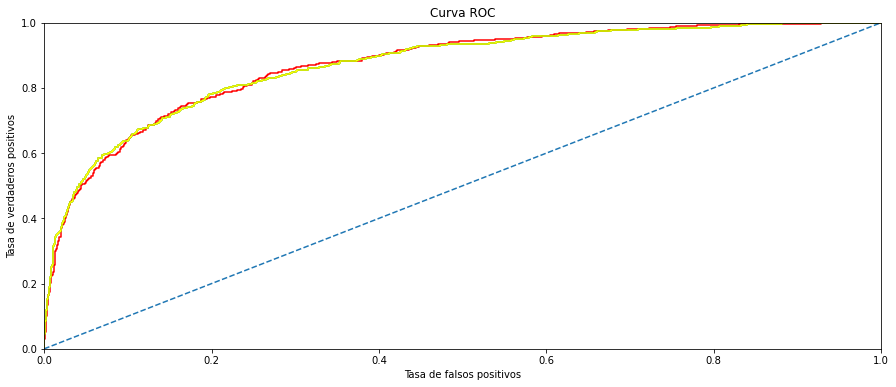

In [83]:
# Graficando ROC
probabilities_valid_pesos = model_rfc_pesos.predict_proba(X_test)
probabilities_one_valid_pesos = probabilities_valid_pesos[:, 1]
fpr_pesos, tpr_pesos, thresholds_pesos = roc_curve(y_test,probabilities_one_valid_pesos)

probabilities_valid_sobremuestreo = model_rfc_sobremuestreo.predict_proba(X_test)
probabilities_one_valid_sobremuestreo = probabilities_valid_sobremuestreo[:, 1]
fpr_sobremuestreo, tpr_sobremuestreo, thresholds_sobremuestreo = roc_curve(y_test,probabilities_one_valid_sobremuestreo)

probabilities_valid_submuestreo = model_rfc_sobremuestreo.predict_proba(X_test)
probabilities_one_valid_submuestreo = probabilities_valid_submuestreo[:, 1]
fpr_submuestreo, tpr_submuestreo, thresholds_submuestreo = roc_curve(y_test,probabilities_one_valid_submuestreo)

plt.figure(figsize=(15,6))
plt.plot(fpr_pesos,tpr_pesos,color='red')
plt.plot(fpr_sobremuestreo,tpr_sobremuestreo,color='green')
plt.plot(fpr_submuestreo,tpr_submuestreo,color='yellow')

# Curva ROC para modelo aleatorio (parece una línea recta)
plt.plot([0, 1], [0, 1], linestyle='--')

# Límites para los ejes de 0 a 1 
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

# Nombre de los ejes "Tasa de falsos positivos" y "Tasa de verdaderos positivos"
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")
plt.show()

Como podemos observar las curvas se encuentran por encima de la línea recta, esto nos indica que la `tasa de verdaderos positivos` se encuentra por encima de un modelo líneal y por tanto sus predicciones son mejores así también su calidad. Para saber cuanto difiere el modelo de predicción del modelo líneal debemos calcular `AUC-ROC (Área Bajo la Curva ROC)`.

## AUC-ROC (Área Bajo la Curva ROC)

In [84]:
# Calculando "AUC-ROC"
auc_roc_pesos = roc_auc_score(y_test,probabilities_one_valid_pesos)
auc_roc_sobremuestreo = roc_auc_score(y_test,probabilities_one_valid_sobremuestreo)
auc_roc_submuestreo = roc_auc_score(y_test,probabilities_one_valid_submuestreo)

print("AUC-ROC para 'Ajuste de pesos':",auc_roc_pesos)
print("AUC-ROC para 'Sobremuestreo':",auc_roc_sobremuestreo)
print("AUC-ROC para 'Submuestreo':",auc_roc_submuestreo)

AUC-ROC para 'Ajuste de pesos': 0.8708044573176539
AUC-ROC para 'Sobremuestreo': 0.8701489694273725
AUC-ROC para 'Submuestreo': 0.8701489694273725


El área bajo la curva es de al menos `87%` aproximadamente, esto quiere decir que tenemos un modelo de calidad aceptable que con refuerzo de reentrenamiento puede mejorar su calidad sin perder de vista todo lo anteriormente realizado y el enfoque ligeramente con mejor desempeño fue el `Ajuste de pesos` con una ligera área superior que los restantes.

# Conclusiones

Trabajando este proyecto se reforzo lo visto durante el sprint ademas de entender con más detalle las métricas de evaluación de calidad de los modelos de clasificación. Es importante entender las demandas del problema pues de esto depende el punto de partida para abordarlo, primeramente trabajando los datos al punto de tener información relevante para el modelo y de calidad. Posteriormente identificar de que tipo de problema es el que tenemos enfrente pues de esto depende el modelo de machine learning a utilizar que para este caso fue un modelo de `clasificación`.

Una vez identificando el tipo de problema debemos trabajar con los datos contenidos en nuestro set pues para este problema fue necesario hacer uso técnicas de etiquetación, esto con el fin de poder convetir a números los datos categóricos pues los modelos unicaménte pueden procesar datos numéricos. Al mismo tiempo que se trabajan los datos categóricos debemos conocer como es el funcionamiento del algorítmo, si bien no a detalle, saber superficialmente como trabaja pues de esto depende el consumo de información que realizara. Para el caso de los modelos que trabajan basados en árboles se debe usan usar técnicas de `codificación de etiquetas` estos es porque este tipo de algoritmos no reciben la información de forma masiva, reciben fila a fila y de esa forma trabajan los datos, ademas cuando la información marca una relación de clases jerárquica es altamente recomendable de usar, mientras no. Por el otro lado, se puede usar `One Hot Encoder` puesto que el resto de algoritmos tienen la capacidad de consumir la información en bloque y poder trabajarla.

Si bien podemos tener un modelo que arroje un rendimiento óptimo, debemos tener cuidado cuando tengamos problemas de desbalance en nuestro set de datos pues esto puede generar tendencia de predicción hacia un resultado provocando la nula eficiencia del modelo. Para poder trabajar y evaluar el desempeño del modelo una vez se `balancean las clases` contamos con diferentes métricas que nos permiten darnos una idea de la calidad de predicción del modelo, tal es el caso de `recall`, `precision` y `f1`.

Por último y con fines de explicación contamos con métodos que nos permiten identificar la efectividad del modelo en comparación con las predicciones de un modelo aleatorio, es decir, un modelo líneal; de manera visual, encontramos `ROC` que nos traza la curva de predicción de `Verdaderos Positivos` del modelo mientras que `AUC-ROC` permite medir el área bajo la curva anteriormente mencionada.

En conclusión el módelo de clasificación `Bosques Aleatorios`, utilizando un técnica de balanceo de `ajuste de pesos de clases` nos proporciona una eficiencia del `82%` de predicción con una calidad del `87%` en comparación con un modelo aleatorio, arrojando un valor para `F1` de `0.6191`, lo que significa un balance considerablemente más elevado que el solo entrenar el modelo con la información preprocesada.